<a href="https://colab.research.google.com/github/jiwonlee-0218/colab/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning

케라스에서 가져올 수 있도록 해둔 모델들에 대해서는 [케라스 도큐먼트](https://keras.io/applications/)를 참고해주세요.  
Ng 교수님 영상에서 보았던 모델들은 모두 사용가능합니다.  
크기가 큰 모델들은 가져오는 데에 시간이 좀 더 걸립니다.  


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, Activation
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
import matplotlib.pyplot as plt

## Cifar 10

https://www.cs.toronto.edu/~kriz/cifar.html

In [ ]:
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# 1) 형 변환

x_train = x_train.astype('float32') # 32비트 실수형 / np.ndarray.astype은 numpy에 검색하면 형 변환 해주는 함수
x_test = x_test.astype('float32')

# 2) normalize

x_train, x_test = x_train/255., x_test/255.

# 3) one-hot encoding

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test,10)

In [ ]:
x_train.shape

(50000, 32, 32, 3)

---
## VGG16

- include_top: True/False. Network의 최상단 FC-layer들을 포함할지 말지 결정. False로 설정할 시 Feature Extraction에 사용 적합.  
- weights: 기존에 훈련된 파라미터를 사용할지 말지를 결정. None 혹은 'imagenet'  
- input_shape: include_top이 False일 경우만 사용. 입력 데이터의 shape을 지정.  
- pooling: None, 'avg', 'max 중에서 선택 가능.  
- classes: include_top이 True이고 weight을 지정하지 않았을 경우만 사용. 분류할 class의 개수를 지정.  

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
vgg16.trainable = False

x = vgg16.output
x = Flatten()(x)
#x = Dense(64, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

vgg16_customed = Model(inputs=vgg16.input, outputs=x)

vgg16_customed.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [ ]:
vgg16_customed.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = vgg16_customed.fit(x_train, y_train, validation_split=1/5, epochs=3)

Epoch 1/3
 114/1250 [=>............................] - ETA: 3:51 - loss: 2.2465 - accuracy: 0.1739

KeyboardInterrupt: 

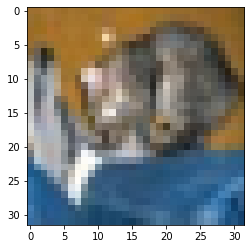

In [ ]:
plt.imshow(x_test[0])

In [ ]:
vgg16_customed.predict(np.expand_dims(x_test[0],axis=0))


array([[0.07396623, 0.14563988, 0.06835179, 0.12027638, 0.07021951,
        0.09772292, 0.11793251, 0.08940488, 0.07640362, 0.14008234]],
      dtype=float32)

---
## ResNet50
들어가는 argument 들은 같습니다.  

In [ ]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow import keras

## 1. 레이어 특정 구간만 학습 가능하도록 설정하기(Fine Tuning)

In [ ]:
resnet50 = ResNet50(weights='imagenet')
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
resnet50.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet50.layers))

# Fine-tune from this layer onwards
fine_tune_at = 50

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet50.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  177


## 2. include_top=False로 설정 후 레이어 덧붙이기

In [ ]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))  # resnet50은 내가 준 모델명이라고 생각    # include_top=False 이므로 최상단레이어(fc레이어esnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))  # resnet50은 내가 준 모델명이라고 생각    # include_top=False 이므로 최상단레이어(fc레이어) 포함시키지 않고 내가 갈아치우겠다는 소리


x = resnet50.output

x = Dropout(0.5)(x) 
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = keras.layers.BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = keras.layers.BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='softmax')(x)


from tensorflow.keras.models import Model
resnet50_customed = Model(inputs=resnet50.input, outputs=x)

for layer in resnet50_customed.layers[:-9]:
    layer.trainable = False

94773248/94765736 [==============================] - 12s 0us/step


In [ ]:
resnet50_customed.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
resnet50_customed.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________